**dependies**

In [2]:

import tensorflow
print(tensorflow.__version__)


2.12.0


**importing the dataset**

In [1]:
!curl -L "https://app.roboflow.com/ds/9bEhcOvjo3?key=bzf3xSsAj3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1689      0 --:--:-- --:--:-- --:--:--  1689
100 38.9M  100 38.9M    0     0  9186k      0  0:00:04  0:00:04 --:--:-- 11.6M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/kidney-stone/
 extracting: test/kidney-stone/0001-N639SD00_jpg.rf.061396edfc2c835c4421eeb95c464503.jpg  
 extracting: test/kidney-stone/0001-N639TBO2_jpg.rf.14bbfef1f630766c9639243197ff0fca.jpg  
 extracting: test/kidney-stone/0002-N46FSOG2_jpg.rf.8dd3c37af6e5d415c59f7e60477b3e32.jpg  
 extracting: test/kidney-stone/202305131139030242_jpg.rf.3bd7eaf1bcb73989f9f6318a8d6f748a.jpg  
 extracting: test/kidney-stone/202305151224500090_jpg.rf.f1fecc672887a5fe2219de9c74405328.jpg  
 extracting: test/kidney-stone/kid-stone-1-_jpg.rf.c82093fea6e8c06cbd

**Data Preprocessing**

In [6]:

import cv2,os
data_path='/content/images/train'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'normal kidney': 0, 'kidney-stone': 1}
['normal kidney', 'kidney-stone']
[0, 1]


In [7]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the image  into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

**Recale and assign catagorical lables**

In [8]:

import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [9]:
new_target.shape


(1113, 2)

In [10]:

data.shape


(1113, 100, 100, 3)

In [11]:

data.shape[1:]

(100, 100, 3)

<h1>CNN Model<h1>

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       5600      
                                                                 
 activation (Activation)     (None, 98, 98, 200)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 100)       180100    
                                                                 
 activation_1 (Activation)   (None, 47, 47, 100)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 100)      0         
 2D)                                                    

**Splittiong data into traning and testing**

In [14]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [15]:

train_data.shape

(1001, 100, 100, 3)

In [16]:
train_target.shape

(1001, 2)

In [18]:
history=model.fit(train_data,train_target,epochs=100,validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0686 - accuracy: 0.9775 - val_loss: 0.7688 - val_accuracy: 0.7960
Epoch 2/100
25/25 [==============================] - 1s 39ms/step - loss: 0.0560 - accuracy: 0.9812 - val_loss: 0.9025 - val_accuracy: 0.7761
Epoch 3/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0499 - accuracy: 0.9825 - val_loss: 0.8833 - val_accuracy: 0.7861
Epoch 4/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0321 - accuracy: 0.9912 - val_loss: 1.0391 - val_accuracy: 0.7811
Epoch 5/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0399 - accuracy: 0.9812 - val_loss: 0.9946 - val_accuracy: 0.8010
Epoch 6/100
25/25 [==============================] - 1s 41ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 1.0269 - val_accuracy: 0.8109
Epoch 7/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0329 - accuracy: 0.9862 - val_loss: 1.0690 - val_accuracy: 0.7910
Epoch 

In [19]:

model.save('model.h5')

In [20]:
from matplotlib import pyplot as plt


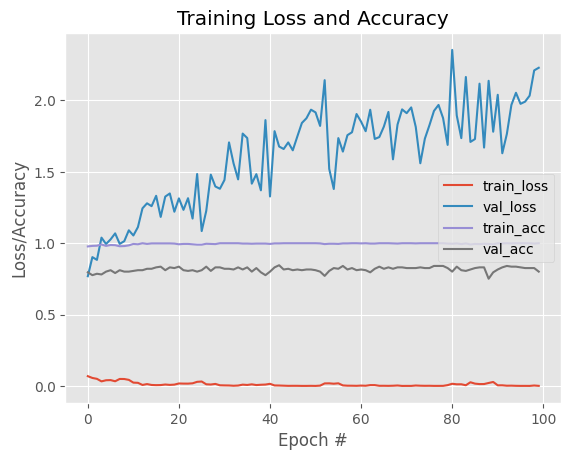

In [22]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")